In [1]:
import sys
sys.path.append('..')
from spyral.core.config import load_config
from spyral.core.workspace import Workspace
from spyral.core.frib_trace import FRIB_TRACE_LENGTH
from spyral.core.frib_event import FribEvent, IC_COLUMN, SI_COLUMN
from spyral.phase_1 import get_event_range
import h5py as h5
import matplotlib.pyplot as plt
import numpy.random as random
import numpy as np
from pathlib import Path

In [2]:
config = load_config(Path('../local_config.json'))
# Tweak some parameters
# config.trace.peak_threshold = 1

# Create our workspace
ws = Workspace(config.workspace)

In [3]:
run_number = config.run.run_min
trace_file: h5.File = h5.File(ws.get_trace_file_path(run_number))

In [4]:
frib_group: h5.Group = trace_file['frib']
trace_group: h5.Group = frib_group['evt']

In [5]:
# Ask the trace file for the range of events
min_event, max_event = get_event_range(trace_file)
# Select a random event
event_number = random.randint(min_event, max_event)
print(f'Event {event_number}')
# Can always overwrite with hardcoded event number if needed
# event_number = 19637

trace_data: h5.Dataset = trace_group[f'evt{event_number}_1903']

Event 15515


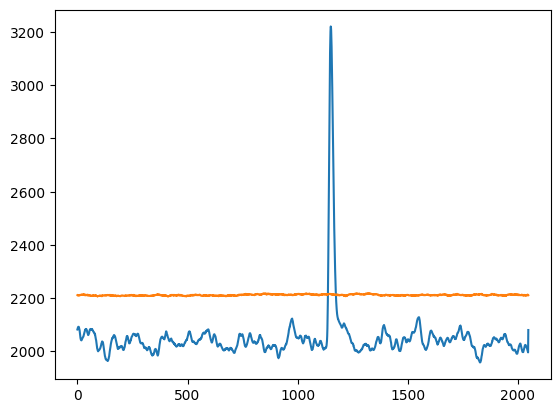

In [6]:
sample_range = np.arange(0, FRIB_TRACE_LENGTH)
plt.plot(sample_range, trace_data[:, IC_COLUMN])
plt.plot(sample_range, trace_data[:, SI_COLUMN])

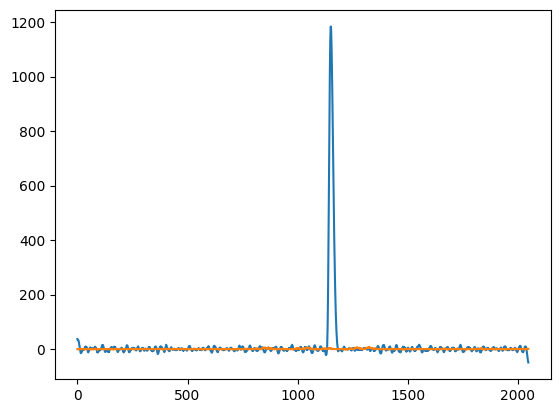

In [7]:
event = FribEvent(trace_data, event_number)
plt.plot(sample_range, event.get_ic_trace().trace)
plt.plot(sample_range, event.get_si_trace().trace)

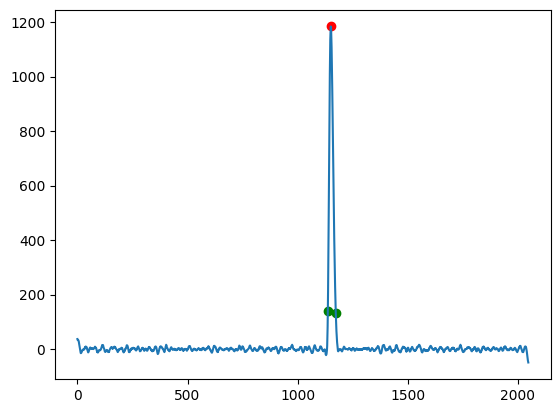

In [8]:
plt.plot(sample_range, event.get_ic_trace().trace)
for peak in event.get_ic_trace().get_peaks():
    plt.scatter(peak.centroid, peak.amplitude, color='red')
    plt.scatter(peak.negative_inflection, event.get_ic_trace().trace[int(peak.negative_inflection)], color='green')
    plt.scatter(peak.positive_inflection, event.get_ic_trace().trace[int(peak.positive_inflection)], color='green')
plt.show()

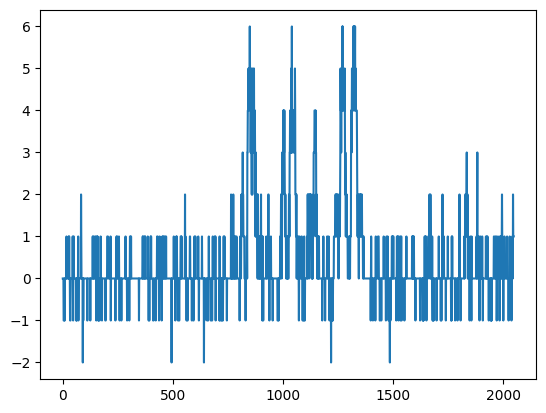

In [9]:
plt.plot(sample_range, event.get_si_trace().trace)
for peak in event.get_si_trace().get_peaks():
    plt.scatter(peak.centroid, peak.amplitude, color='red')
    plt.scatter(peak.negative_inflection, event.get_si_trace().trace[int(peak.negative_inflection)], color='green')
    plt.scatter(peak.positive_inflection, event.get_si_trace().trace[int(peak.positive_inflection)], color='green')
plt.show()

In [10]:
good_peak = event.get_good_ic_peak()
print(good_peak)

Peak(centroid=1150, positive_inflection=1137, negative_inflection=1173, amplitude=1184.0, uncorrected_amplitude=0.0, integral=25162)
